Get the data

Download the data

In [3]:
!pip install kagglehub
import kagglehub
import os
import pandas as pd
!pip install scikeras
!pip install scikit-learn==1.4.2 imbalanced-learn==0.12.2
!pip install keras-tuner --upgrade
!pip install tensorflow
!pip install xgboost

# Download the latest version of the dataset
path = kagglehub.dataset_download("aouatifcherdid/healthcare-dataset-stroke-data")
df = pd.read_csv(f"{path}/healthcare-dataset-stroke-data.csv")

Check missing values

In [5]:
# Check for missing values
print("Missing values in each column:")
print(df.isnull().sum())

print("Descriptive statistics:")
print(df.describe())

Missing values in each column:
id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64
Descriptive statistics:
                 id          age  hypertension  heart_disease  \
count   5110.000000  5110.000000   5110.000000    5110.000000   
mean   36517.829354    43.226614      0.097456       0.054012   
std    21161.721625    22.612647      0.296607       0.226063   
min       67.000000     0.080000      0.000000       0.000000   
25%    17741.250000    25.000000      0.000000       0.000000   
50%    36932.000000    45.000000      0.000000       0.000000   
75%    54682.000000    61.000000      0.000000       0.000000   
max    72940.000000    82.000000      1.000000       1.000000   

       avg_glucose_level          bmi       st

Feature Engineering

After removing missing values, dataset shape: (4909, 12)
Missing values in each column:
id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64


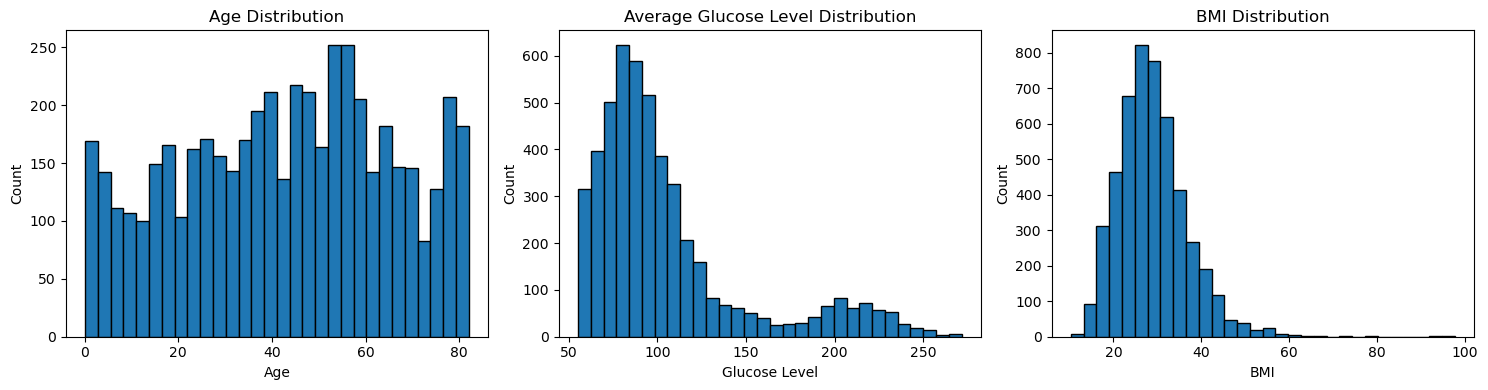

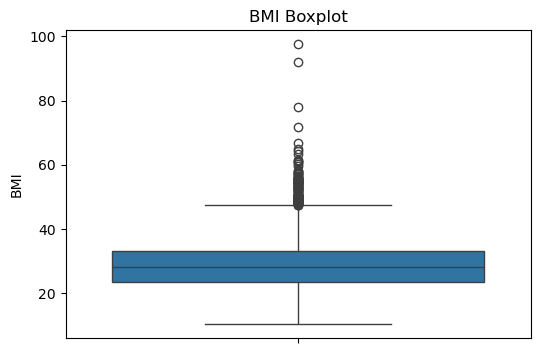

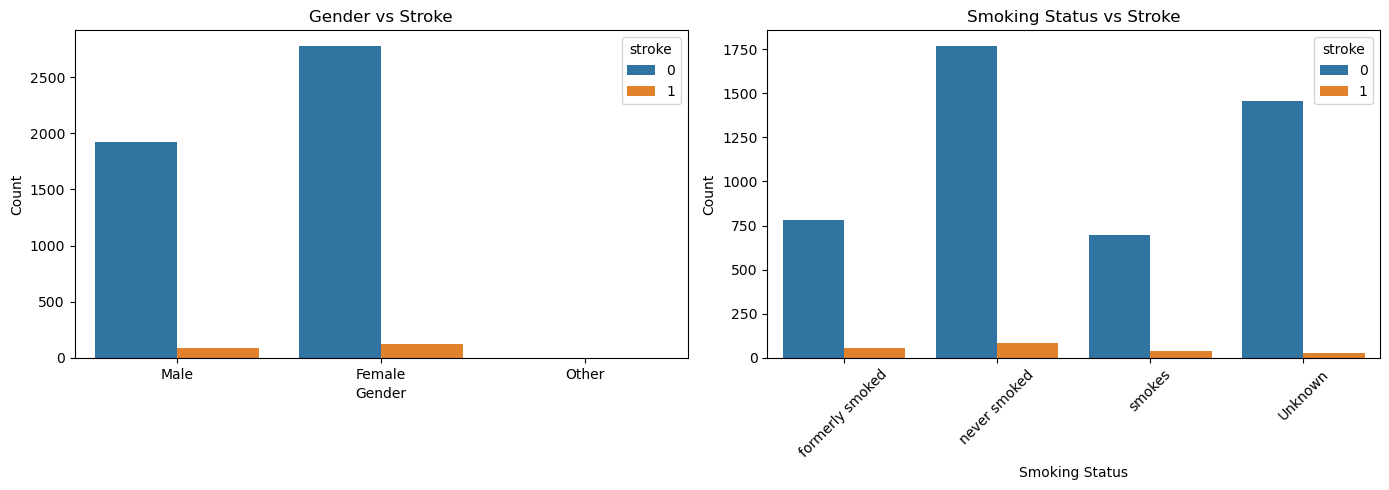

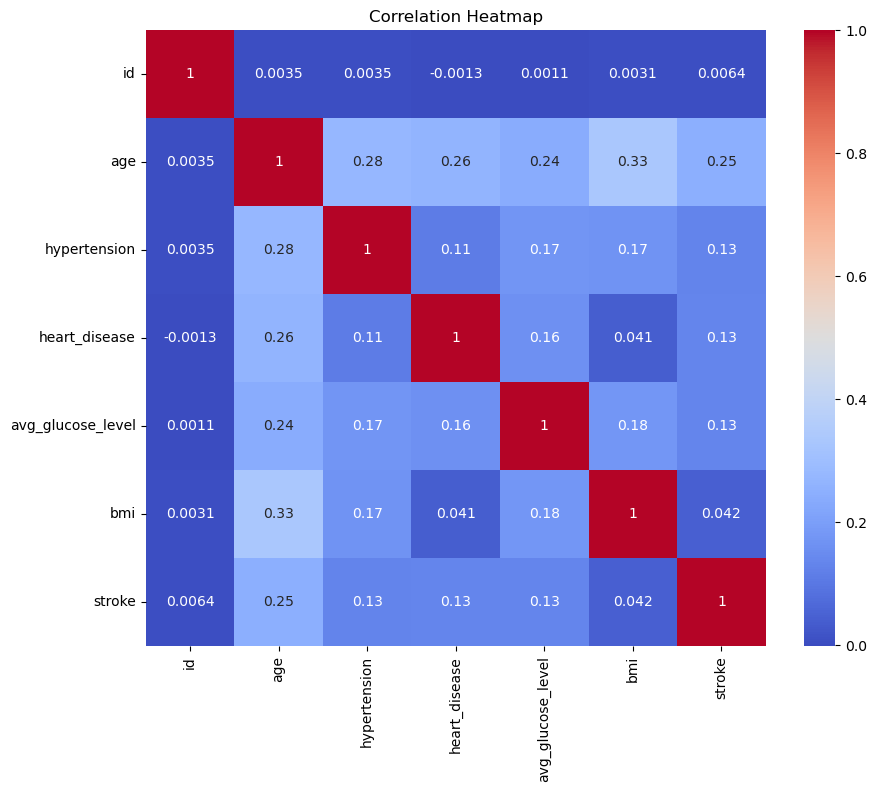

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Remove rows with missing values
df_clean = df.dropna()
print("After removing missing values, dataset shape:", df_clean.shape)
print("Missing values in each column:")
print(df_clean.isnull().sum())

# Visualize the distributions of numerical features on the cleaned dataset

plt.figure(figsize=(15, 4))

# Age distribution
plt.subplot(1, 3, 1)
plt.hist(df_clean['age'], bins=30, edgecolor='black')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')

# Average glucose level distribution
plt.subplot(1, 3, 2)
plt.hist(df_clean['avg_glucose_level'], bins=30, edgecolor='black')
plt.title('Average Glucose Level Distribution')
plt.xlabel('Glucose Level')
plt.ylabel('Count')

# BMI distribution
plt.subplot(1, 3, 3)
plt.hist(df_clean['bmi'], bins=30, edgecolor='black')
plt.title('BMI Distribution')
plt.xlabel('BMI')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

# Boxplot for BMI to detect outliers
plt.figure(figsize=(6, 4))
sns.boxplot(y=df_clean['bmi'])
plt.title('BMI Boxplot')
plt.ylabel('BMI')
plt.show()

# Visualize categorical variables with respect to the target variable 'stroke'
plt.figure(figsize=(14, 5))

# Gender vs Stroke outcome
plt.subplot(1, 2, 1)
sns.countplot(x='gender', hue='stroke', data=df_clean)
plt.title('Gender vs Stroke')
plt.xlabel('Gender')
plt.ylabel('Count')

# Smoking Status vs Stroke outcome
plt.subplot(1, 2, 2)
sns.countplot(x='smoking_status', hue='stroke', data=df_clean)
plt.title('Smoking Status vs Stroke')
plt.xlabel('Smoking Status')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Correlation heatmap
plt.figure(figsize=(10, 8))
# Select only numerical features for correlation calculation
numerical_df = df.select_dtypes(include=['number'])
corr_matrix = numerical_df.corr()  # Calculate correlation on numerical features
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


Stroke Rate by Age Group:
  age_group    stroke
0      0-30  0.000674
1     31-50  0.012725
2     51-70  0.058065
3    71-100  0.158273


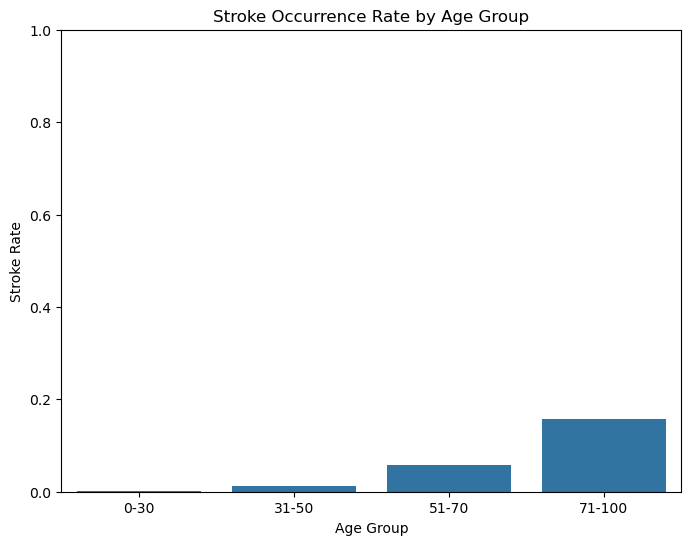

In [8]:
# Ensure df_clean is an independent copy
df_clean = df_clean.copy()

# Create an age group variable (bins)
age_bins = [0, 30, 50, 70, 100]
age_labels = ['0-30', '31-50', '51-70', '71-100']
df_clean['age_group'] = pd.cut(df_clean['age'], bins=age_bins, labels=age_labels, right=False)

# Calculate the stroke rate
age_stroke_rate = df_clean.groupby('age_group', observed=True)['stroke'].mean().reset_index()

print("Stroke Rate by Age Group:")
print(age_stroke_rate)

# Plot the stroke rate by age group using a bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x='age_group', y='stroke', data=age_stroke_rate)
plt.title("Stroke Occurrence Rate by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Stroke Rate")
plt.ylim(0, 1)
plt.show()

Data Processing

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

# Handle missing values (for bmi column)
df['bmi'].fillna(df['bmi'].mean(), inplace=True)

# Data Preparation & Preprocessing Pipeline
# Separate features and target variable
X = df_clean.drop('stroke', axis=1)
y = df_clean['stroke']

# Define numerical and categorical features
numeric_cols = ['age', 'avg_glucose_level', 'bmi']
categorical_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']


In [11]:
# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Build a preprocessing pipeline: standardize numeric features and apply OneHotEncoder to categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), categorical_cols)
    ]
)
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

X_train_transformed = pipeline.fit_transform(X_train)
X_test_transformed = pipeline.transform(X_test)

print("Transformed training set shape:", X_train_transformed.shape)
print("Transformed test set shape:", X_test_transformed.shape)


Transformed training set shape: (3927, 14)
Transformed test set shape: (982, 14)


Build Neural Network Model

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,073 (12.00 KB)

 Trainable params: 3,073 (12.00 KB)

 Non-trainable params: 0 (0.00 B)

Computed class weights: {0: 0.5222340425531915, 1: 11.74401913875598}
Epoch 1/150
 1/99 ━━━━━━━━━━━━━━━━━━━━ 40s 418ms/step - accuracy: 0.4375 - loss: 1.1483
Epoch 1: val_loss improved from inf to 0.44261, saving model to best_model.keras
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6819 - loss: 0.9890 - val_accuracy: 0.9580 - val_loss: 0.4426
Epoch 2/150
 1/99 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8438 - loss: 1.4485
Epoch 2: val_loss improved from 0.44261 to 0.38875, saving model to best_model.keras
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step - accuracy: 0.8363 - loss: 0.9275 - val_accuracy: 0.9567 - val_loss: 0.3887
Epoch 3/150
 1/99 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9062 - loss: 0.9330
Epoch 3: val_loss improved from 0.38875 to 0.35098, saving model to best_model.keras
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step - accuracy: 0.8518 - loss: 0.8744 - val_accuracy: 0.9478 - val_loss: 0.3510
Epoch 4/150
 1/99 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8125 - 

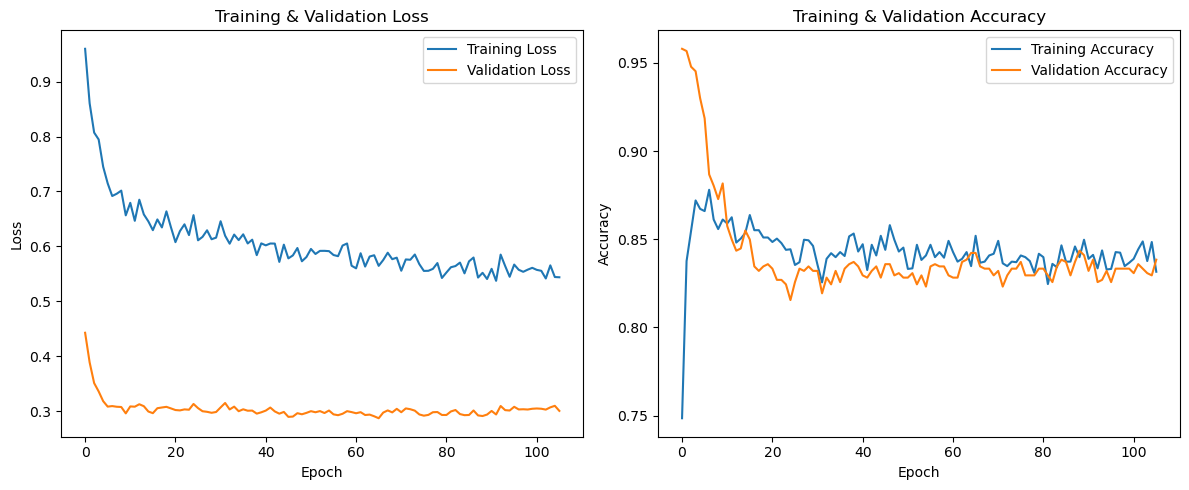

In [13]:
# Build and Compile Neural Network Model

model = models.Sequential([
    layers.InputLayer(input_shape=(X_train_transformed.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.6),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.6),
    layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

# Training: Compute Class Weights and Setup Callbacks
# Compute class weights
computed_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weight_dict = {i: weight for i, weight in enumerate(computed_weights)}
print("Computed class weights:", class_weight_dict)

manual_class_weight = {0: 1, 1: 10}

# Early Stop
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True)
checkpoint = callbacks.ModelCheckpoint("best_model.keras", monitor='val_loss', save_best_only=True, verbose=1)

history = model.fit(
    X_train_transformed, y_train,
    epochs=150,
    validation_split=0.2,
    batch_size=32,
    class_weight=manual_class_weight,
    callbacks=[early_stop, checkpoint]
)

# Plot the training process
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()
plt.tight_layout()
plt.show()


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step - accuracy: 0.8498 - loss: 0.2796
Test loss: 0.2932
Test accuracy: 0.8371
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step


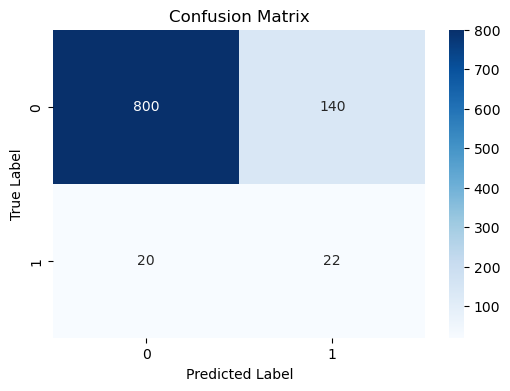

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.85      0.91       940
           1       0.14      0.52      0.22        42

    accuracy                           0.84       982
   macro avg       0.56      0.69      0.56       982
weighted avg       0.94      0.84      0.88       982



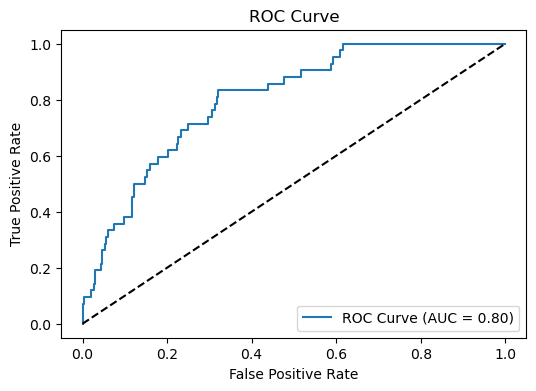

In [14]:
# Model Evaluation & Error Analysis
loss, accuracy = model.evaluate(X_test_transformed, y_test)
print("Test loss: {:.4f}".format(loss))
print("Test accuracy: {:.4f}".format(accuracy))


# Make predictions on the test set
y_pred_prob = model.predict(X_test_transformed)
y_pred = (y_pred_prob > 0.5).astype(int)

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Plot the ROC curve and calculate AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc='lower right')
plt.show()

Build Logistic Model

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.74      0.85       940
           1       0.11      0.69      0.19        42

    accuracy                           0.74       982
   macro avg       0.54      0.72      0.52       982
weighted avg       0.94      0.74      0.82       982



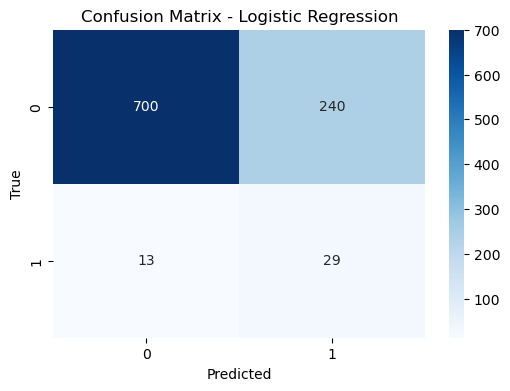

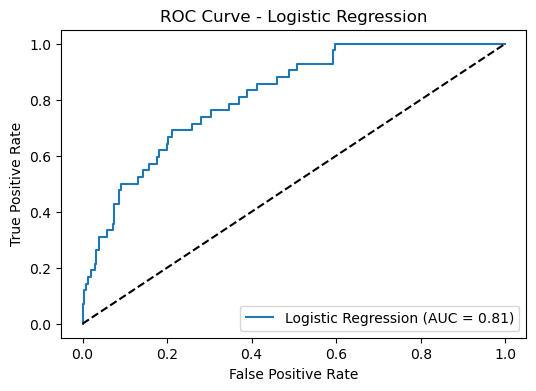

In [16]:
# Logistic Regression Model
# Build a logistic regression model, using 'balanced' class_weight to help address class imbalance
logreg = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
logreg.fit(X_train_transformed, y_train)

# Make predictions on the test set
y_pred_logreg = logreg.predict(X_test_transformed)
y_pred_logreg_prob = logreg.predict_proba(X_test_transformed)[:, 1]

# Print classification report
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_logreg))

# Plot confusion matrix
cm_logreg = confusion_matrix(y_test, y_pred_logreg)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_logreg, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Plot the ROC curve and calculate AUC
fpr_logreg, tpr_logreg, _ = roc_curve(y_test, y_pred_logreg_prob)
roc_auc_logreg = auc(fpr_logreg, tpr_logreg)
plt.figure(figsize=(6, 4))
plt.plot(fpr_logreg, tpr_logreg, label=f'Logistic Regression (AUC = {roc_auc_logreg:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend(loc='lower right')
plt.show()

Build XGBoost Model

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       940
           1       0.08      0.02      0.04        42

    accuracy                           0.95       982
   macro avg       0.52      0.51      0.50       982
weighted avg       0.92      0.95      0.93       982



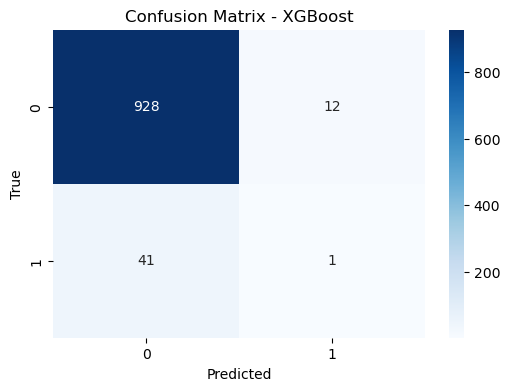

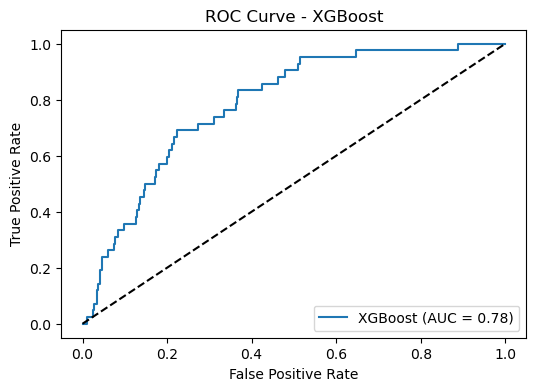

In [18]:
# Build the XGBoost model
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb_clf)
])

# Train the XGBoost model
xgb_pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred_xgb = xgb_pipeline.predict(X_test)
y_pred_xgb_prob = xgb_pipeline.predict_proba(X_test)[:, 1]

# Print classification report
print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))

# Plot confusion matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - XGBoost")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Plot the ROC curve and calculate the AUC
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_xgb_prob)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)
plt.figure(figsize=(6, 4))
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_xgb:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - XGBoost")
plt.legend(loc='lower right')
plt.show()


Compare three models

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Comparison of Test Metrics:
                     Accuracy  Log Loss   ROC AUC
Logistic Regression  0.742363  0.483071  0.813298
XGBoost              0.946029  0.203192  0.783992
Neural Network       0.837067  0.293173  0.801317


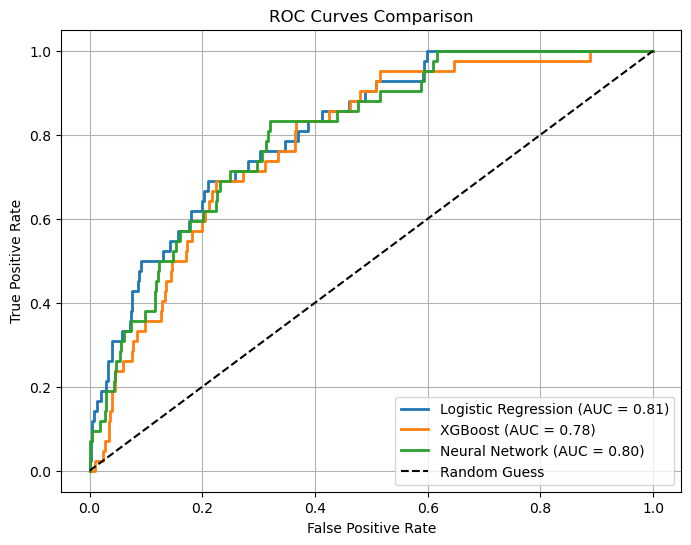

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, roc_curve
import numpy as np

# Calculate test metrics for each model

# Logistic Regression
y_pred_logreg = logreg.predict(X_test_transformed)
y_pred_logreg_prob = logreg.predict_proba(X_test_transformed)[:, 1]  # Obtain probability for the positive class
acc_logreg = accuracy_score(y_test, y_pred_logreg)
loss_logreg = log_loss(y_test, y_pred_logreg_prob)
roc_auc_logreg = roc_auc_score(y_test, y_pred_logreg_prob)

# XGBoost
y_pred_xgb = xgb_pipeline.predict(X_test)
y_pred_xgb_prob = xgb_pipeline.predict_proba(X_test)[:, 1]
acc_xgb = accuracy_score(y_test, y_pred_xgb)
loss_xgb = log_loss(y_test, y_pred_xgb_prob)
roc_auc_xgb = roc_auc_score(y_test, y_pred_xgb_prob)

# Neural Network
# Use 'evaluate' to obtain loss and accuracy
loss_nn, acc_nn = model.evaluate(X_test_transformed, y_test, verbose=0)
y_pred_nn_prob = model.predict(X_test_transformed).ravel() 
y_pred_nn = (y_pred_nn_prob > 0.5).astype(int)
roc_auc_nn = roc_auc_score(y_test, y_pred_nn_prob)

# Compile metrics into a DataFrame
metrics_df = pd.DataFrame({
    'Accuracy': [acc_logreg, acc_xgb, acc_nn],
    'Log Loss': [loss_logreg, loss_xgb, loss_nn],
    'ROC AUC': [roc_auc_logreg, roc_auc_xgb, roc_auc_nn]
}, index=['Logistic Regression', 'XGBoost', 'Neural Network'])

print("Comparison of Test Metrics:")
print(metrics_df)

# Plot the ROC curves for all three models
fpr_logreg, tpr_logreg, _ = roc_curve(y_test, y_pred_logreg_prob)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_xgb_prob)
fpr_nn, tpr_nn, _   = roc_curve(y_test, y_pred_nn_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr_logreg, tpr_logreg, label=f'Logistic Regression (AUC = {roc_auc_logreg:.2f})', linewidth=2)
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_xgb:.2f})', linewidth=2)
plt.plot(fpr_nn, tpr_nn, label=f'Neural Network (AUC = {roc_auc_nn:.2f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves Comparison")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

Comparison of Multiple Classifiers by using RandomizedSearchCV

RandomizedSearchCV 1


Best parameters for MLP: {'solver': 'adam', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (100,), 'alpha': 0.001, 'activation': 'relu'}
Best CV Recall for MLP: 0.0

Best parameters for Logistic Regression: {'solver': 'liblinear', 'penalty': 'l2', 'class_weight': {0: 1, 1: 15}, 'C': 0.01}
Best CV Recall for Logistic Regression: 0.7549019607843137

Best parameters for XGBoost: {'subsample': 1.0, 'scale_pos_weight': 10, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1}
Best CV Recall for XGBoost: 0.5087344028520498

===== Evaluation for MLP Neural Network =====
Confusion Matrix:
 [[940   0]
 [ 42   0]]

Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98       940
           1       0.00      0.00      0.00        42

    accuracy                           0.96       982
   macro avg       0.48      0.50      0.49       982
weighted avg       0.92      0.96      0.94       982

ROC AUC Score: 0.366


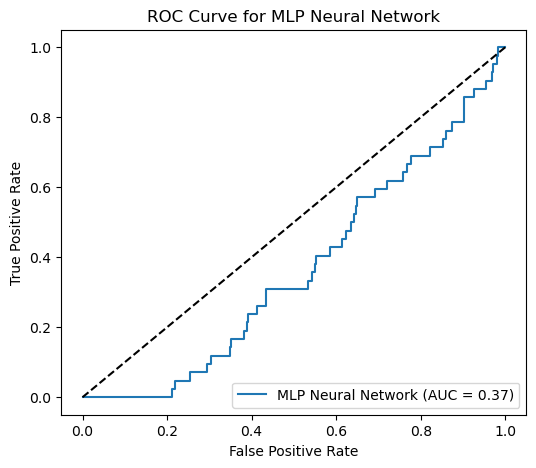


===== Evaluation for Logistic Regression =====
Confusion Matrix:
 [[749 191]
 [ 17  25]]

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.80      0.88       940
           1       0.12      0.60      0.19        42

    accuracy                           0.79       982
   macro avg       0.55      0.70      0.54       982
weighted avg       0.94      0.79      0.85       982

ROC AUC Score: 0.809


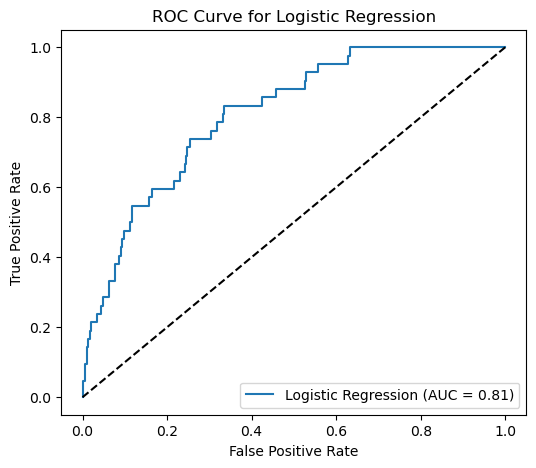


===== Evaluation for XGBoost =====
Confusion Matrix:
 [[820 120]
 [ 19  23]]

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.87      0.92       940
           1       0.16      0.55      0.25        42

    accuracy                           0.86       982
   macro avg       0.57      0.71      0.59       982
weighted avg       0.94      0.86      0.89       982

ROC AUC Score: 0.819


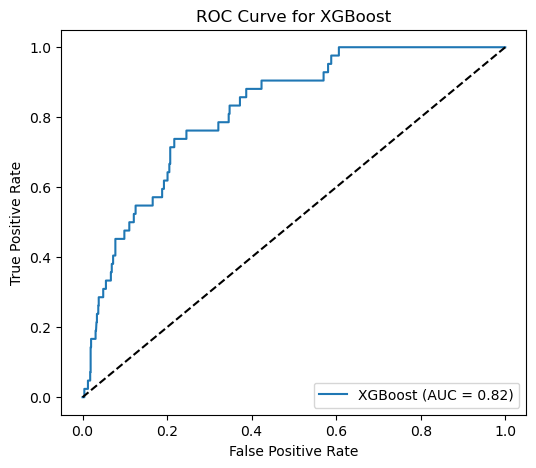

In [23]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPClassifier # Import MLPClassifier
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
# Data Preprocessing Pipeline
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), categorical_cols)
])

# Transform training data
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# SMOTE oversampling after preprocessing
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_transformed, y_train)

# Set scoring metric
scoring = 'recall'

# MLP Neural Network
mlp = MLPClassifier(random_state=42, max_iter=300, early_stopping=True)
mlp_params = {
    'hidden_layer_sizes': [(100,), (50, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],
    'alpha': [0.001, 0.01],
    'learning_rate_init': [0.001, 0.005]
}
mlp_random = RandomizedSearchCV(mlp, mlp_params, cv=5, scoring=scoring, n_iter=5, n_jobs=-1, random_state=42)
mlp_random.fit(X_train_transformed, y_train)
print("\nBest parameters for MLP:", mlp_random.best_params_)
print("Best CV Recall for MLP:", mlp_random.best_score_)

# Logistic Regression
logreg = LogisticRegression(random_state=42, max_iter=500)
logreg_params = {
    'C': [0.01, 0.1, 1],
    'penalty': ['l2'],
    'solver': ['liblinear'],
    'class_weight': [{0:1, 1:10}, {0:1, 1:15}]
}
logreg_random = RandomizedSearchCV(logreg, logreg_params, cv=5, scoring=scoring, n_iter=4, n_jobs=-1, random_state=42)
logreg_random.fit(X_train_transformed, y_train)
print("\nBest parameters for Logistic Regression:", logreg_random.best_params_)
print("Best CV Recall for Logistic Regression:", logreg_random.best_score_)

# XGBoost
xgb = XGBClassifier(eval_metric='logloss', random_state=42)
xgb_params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'scale_pos_weight': [5, 10, 15]
}
xgb_random = RandomizedSearchCV(xgb, xgb_params, cv=5, scoring=scoring, n_iter=5, n_jobs=-1, random_state=42)
xgb_random.fit(X_train_transformed, y_train)
print("\nBest parameters for XGBoost:", xgb_random.best_params_)
print("Best CV Recall for XGBoost:", xgb_random.best_score_)

# Evaluate models
X_test_transformed_eval = preprocessor.transform(X_test)

def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test_transformed_eval)
    y_proba = model.predict_proba(X_test_transformed_eval)[:, 1]

    print(f"\n===== Evaluation for {model_name} =====")
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

    roc_auc = roc_auc_score(y_test, y_proba)
    print(f"ROC AUC Score: {roc_auc:.3f}")

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve for {model_name}")
    plt.legend(loc="lower right")
    plt.show()

evaluate_model(mlp_random.best_estimator_, X_test, y_test, "MLP Neural Network")
evaluate_model(logreg_random.best_estimator_, X_test, y_test, "Logistic Regression")
evaluate_model(xgb_random.best_estimator_, X_test, y_test, "XGBoost")


Feature Importance

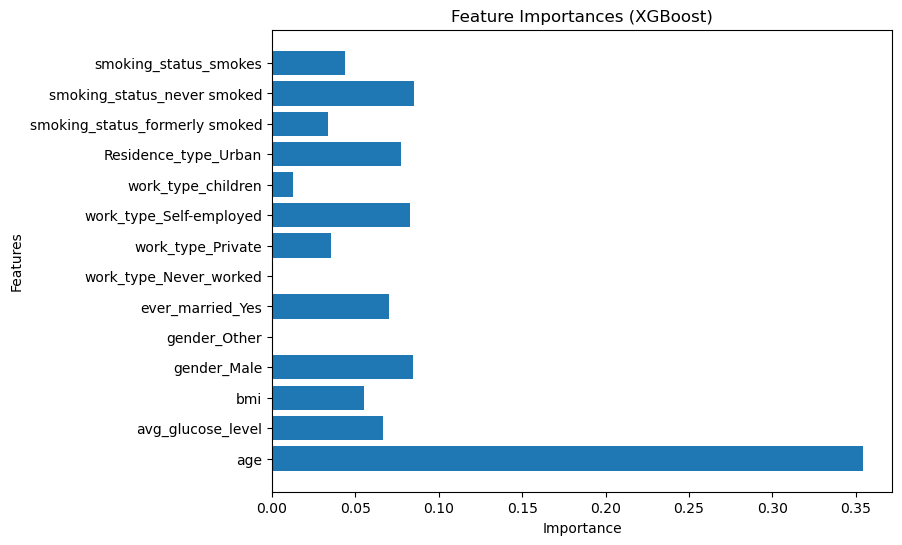

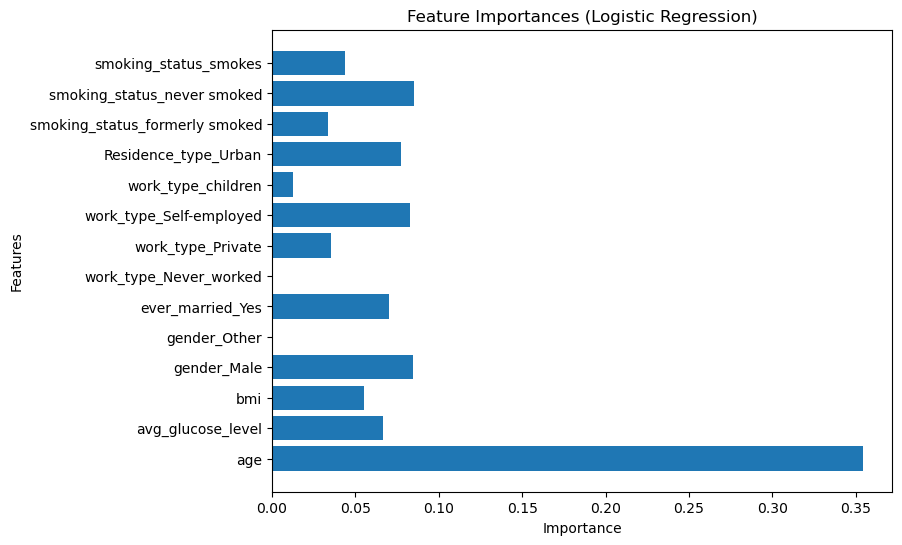

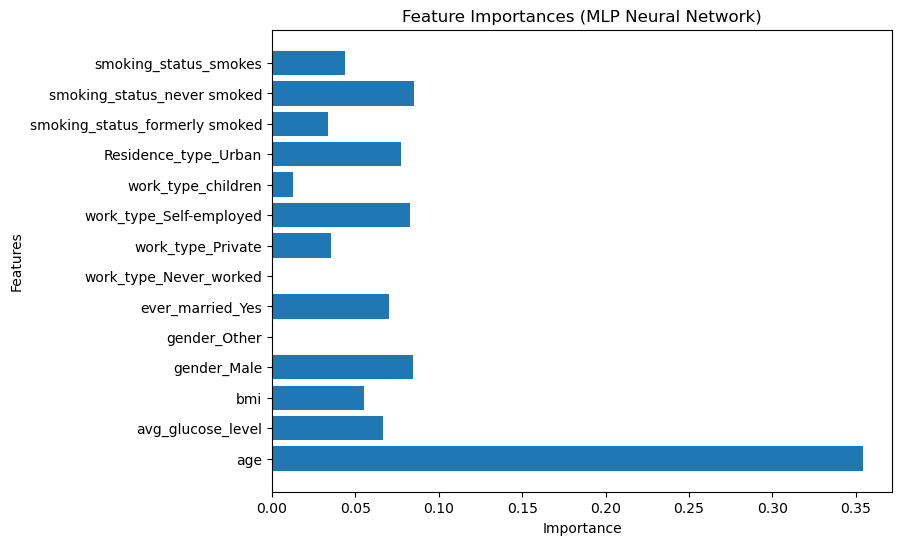

In [25]:
import matplotlib.pyplot as plt

best_xgb_model = xgb_random.best_estimator_
best_logreg_model = logreg_random.best_estimator_
best_mlp_model = mlp_random.best_estimator_

# Retrieve feature names corresponding to OneHotEncoder output
feature_names = pipeline.named_steps['preprocessor'] \
                        .transformers_[1][1] \
                        .get_feature_names_out(categorical_cols)

# Combine numeric and encoded feature names
num_features = numeric_cols  # ['age', 'avg_glucose_level', 'bmi']
all_feature_names = list(num_features) + list(feature_names)

# Extract feature importances
importances = best_xgb_model.feature_importances_

# Plot feature importances
plt.figure(figsize=(8, 6))
plt.barh(all_feature_names, importances)
plt.title("Feature Importances (XGBoost)")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()

plt.figure(figsize=(8, 6))
plt.barh(all_feature_names, importances)
plt.title("Feature Importances (Logistic Regression)")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()

plt.figure(figsize=(8, 6))
plt.barh(all_feature_names, importances)
plt.title("Feature Importances (MLP Neural Network)")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()



Learning Curves

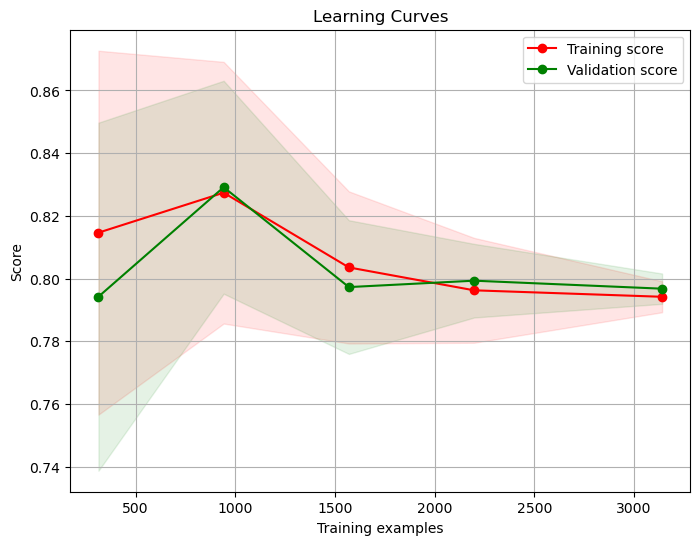

In [27]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

def plot_learning_curves(estimator, X, y):
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X, y, cv=5, scoring='accuracy',
        train_sizes=[0.1, 0.3, 0.5, 0.7, 1.0], shuffle=True, random_state=42
    )
    train_mean = train_scores.mean(axis=1)
    train_std = train_scores.std(axis=1)
    val_mean = val_scores.mean(axis=1)
    val_std = val_scores.std(axis=1)

    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, val_mean, 'o-', color="g", label="Validation score")
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std,
                     alpha=0.1, color="r")
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std,
                     alpha=0.1, color="g")
    plt.title("Learning Curves")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

best_logreg = logreg_random.best_estimator_
best_xgb = xgb_random.best_estimator_
best_nn = mlp_random.best_estimator_
plot_learning_curves(best_logreg, X_train_transformed, y_train)


Hyperparameter Tuning with Keras Tuner for Stroke Classification

In [29]:
import keras_tuner as kt
import tensorflow as tf
from tensorflow.keras import layers, models

def build_model(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(X_train_transformed.shape[1],)))

    # Hyperparameter search: number of units in the hidden layer
    units = hp.Int('units', min_value=32, max_value=256, step=32)
    model.add(tf.keras.layers.Dense(units, activation='relu'))
    model.add(tf.keras.layers.Dropout(hp.Float('dropout', 0.0, 0.6, step=0.1)))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    # Also search for the learning rate
    lr = hp.Choice('learning_rate', values=[1e-3, 5e-4, 1e-4])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Recall()]  
    )
    return model

# Change objective from accuracy to recall
tuner = kt.RandomSearch(
    build_model,
    objective=kt.Objective('val_recall', direction='max'), 
    max_trials=10,
    executions_per_trial=1,
    overwrite=True,
    directory='my_dir',
    project_name='stroke_keras_tuner'
)

tuner.search(
    X_train_transformed, y_train,
    epochs=50,
    validation_split=0.2,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_recall', patience=5, mode='max')] 
)

best_model = tuner.get_best_models(num_models=1)[0]
best_hparams = tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hparams.values)


Trial 10 Complete [00h 00m 01s]
val_recall: 0.0

Best val_recall So Far: 0.6969696879386902
Total elapsed time: 00h 00m 12s
{'units': 96, 'dropout': 0.30000000000000004, 'learning_rate': 0.0001}
